In [1]:
from camera.camera import Camera
from lane_finder.lanefinder import Lanefinder
from imageprocessor.imageprocessor import Imageprocessor

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
cam = Camera("camera1",config_folder = "camera/camera_config")
if cam.is_calibrated == False:
    cam.calibrate_and_draw("camera_cal/", 9, 6)

Initializing camera ...
Found config file ...
Loading configuration for camera ...
Done ...


In [3]:
imageprocessor = Imageprocessor()
# Set perspective transform
image_top_left = (580,458)
image_top_right = (703,458)
image_bottom_left = (252, 678)
image_bottom_right = (1054,678)

birdeye_top_left = (400,20)
birdeye_top_right = (890,20)
birdeye_bottom_left = (400, 700)
birdeye_bottom_right = (890,700)

src = np.float32([image_top_left,image_bottom_left,image_top_right,image_bottom_right])
dst = np.float32([birdeye_top_left,birdeye_bottom_left,birdeye_top_right,birdeye_bottom_right])
imageprocessor.set_perspective_transform(src,dst)



Initializing image processor ..
Done ...


(array([[ -3.79681744e-01,  -1.52267172e+00,   8.79475912e+02],
        [ -5.27355937e-15,  -1.96863927e+00,   8.99730630e+02],
        [ -8.78203760e-18,  -2.39150189e-03,   1.00000000e+00]]),
 array([[  2.44921619e-01,  -7.76763159e-01,   4.83474942e+02],
        [ -2.88657986e-15,  -5.07965077e-01,   4.57031739e+02],
        [ -6.93889390e-18,  -1.21479944e-03,   1.00000000e+00]]))

In [4]:
lanefinder = Lanefinder()

Initializing image processor ..
Default value of sliding window have been set
window_width = 50
window_height = 80
margin = 100
minimum peak for centroid = 15
Done ...


In [5]:
def advanced_lane_lines_pipline(image,cam,imageprocessor,lanefinder,is_visual):
    
    # 1. Undistort image
    image_undistorted = cam.undistort(image)

    # 2. Computer vision
    # 2.1 Thresholding
    gradx=imageprocessor.abs_sobel_threshold(image, orient='x',sobel_kernel=15, sobel_threshold=(150, 250))
    grady=imageprocessor.abs_sobel_threshold(image, orient='y',sobel_kernel=15, sobel_threshold=(10, 50))
    mag_binary=imageprocessor.magnitude_threshold(image, sobel_kernel=15, magnitude_threshold=(50, 200))
    dir_binary=imageprocessor.direction_threshold(image, sobel_kernel=9, direction_threshold=(0.7, 1.3))  
    hls_binary=imageprocessor.hls_color_threshold_h_and_s_or_l(image, h_threshold=(0, 100), l_threshold=(230, 255), s_threshold=(150, 255))

    # 2.2 Region of interest
    roi_top_left = (555,458)
    roi_top_right = (725,458)
    roi_bottom_left = (212, 678)
    roi_bottom_right = (1094,678)
    region = np.array( [[roi_top_left,roi_bottom_left,roi_bottom_right,roi_top_right]], dtype=np.int32 )
    roi_binary = imageprocessor.region_of_interest(image, region)

    # 2.3 Combined
    combined_binary = imageprocessor.combined_threshold_roi(gradx, grady, mag_binary, dir_binary, hls_binary, roi_binary)

    # 2.4 Perspective transform
    warped = imageprocessor.perspective_transform(combined_binary)
    
    # 2.5 Finding lane lines
    left_centroids, right_centroids = lanefinder.find_lane_segments(warped)
    
    # 2.6 Fit poly lines
    left_fit, left_curverad = lanefinder.fit_curve(left_centroids)
    right_fit, right_curverad = lanefinder.fit_curve(right_centroids)
  
    ploty = np.linspace(0, 719, num=720) 
    pleft = np.poly1d(left_fit)
    pright = np.poly1d(right_fit)  
    leftx = np.array([pleft(y) for y in ploty])  
    rightx = np.array([pright(y)for y in ploty])

    
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = imageprocessor.perspective_reverse_transform(color_warp) 
    # Combine the result with the original image
    result = cv2.addWeighted(image_undistorted, 1, newwarp, 0.3, 0)
    ret = np.copy(result)
    if is_visual==True:
        #Plot
        f, (ax11, ax12, ax13,ax14) = plt.subplots(1, 4, figsize=(20,10))
        ax11.imshow(combined_binary, cmap='gray')
        ax11.set_title('Thresholded', fontsize=30)
        ax12.imshow(warped, cmap='gray')
        ax12.set_title('Perspective Transform', fontsize=30)
        ax13.imshow(image)
        ax13.set_title('Original', fontsize=30)
        ax14.imshow(result)
        ax14.set_title('Result', fontsize=30)
        plt.show()
        
    return ret
        


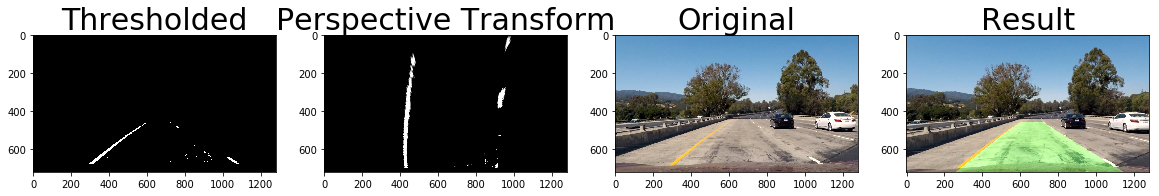

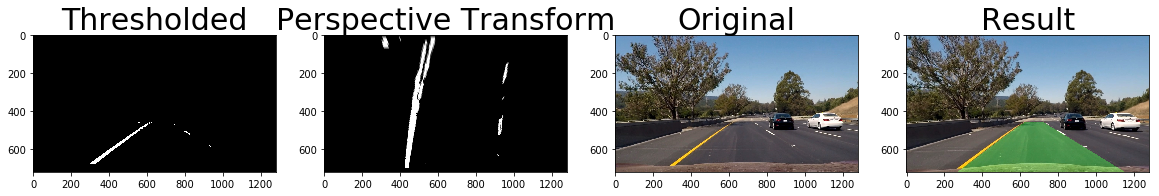

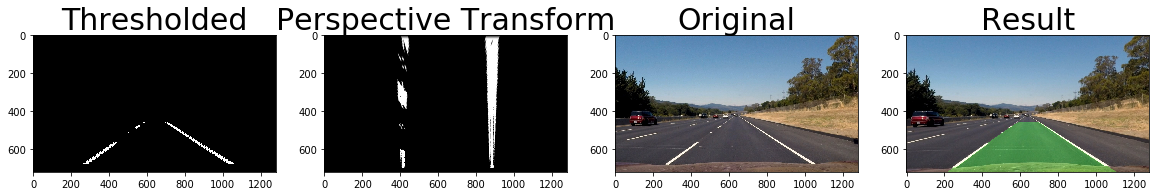

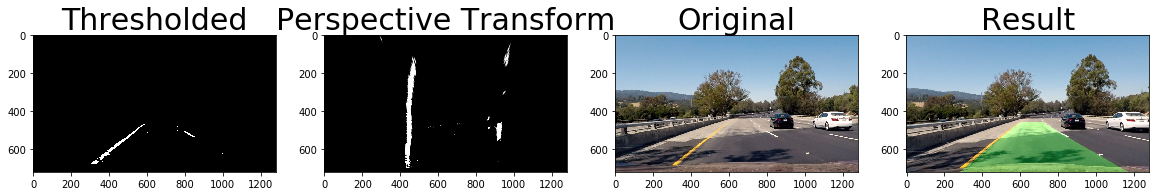

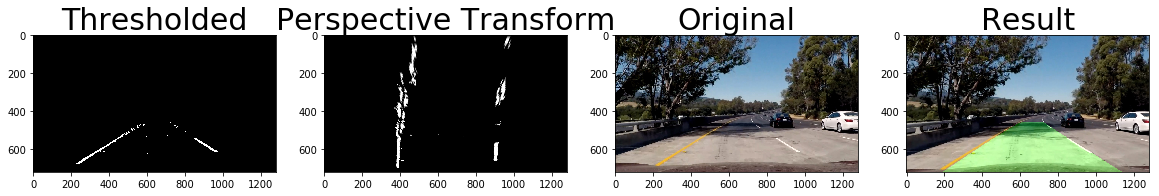

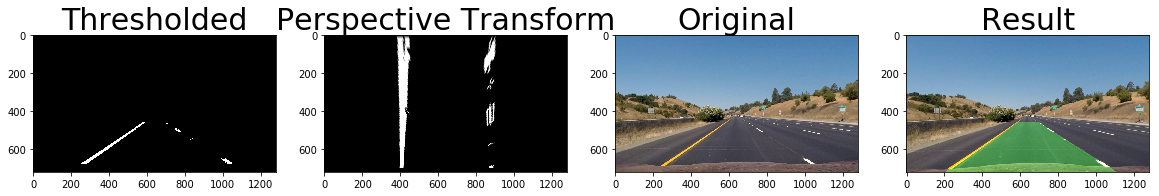

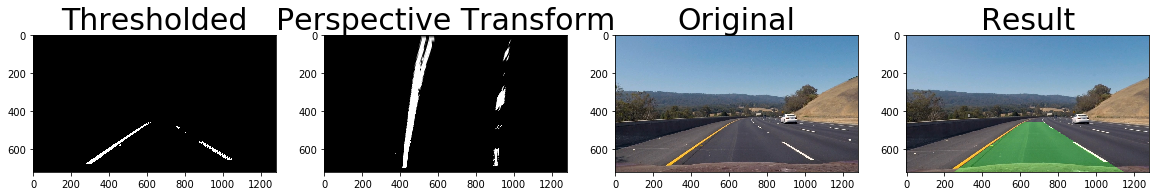

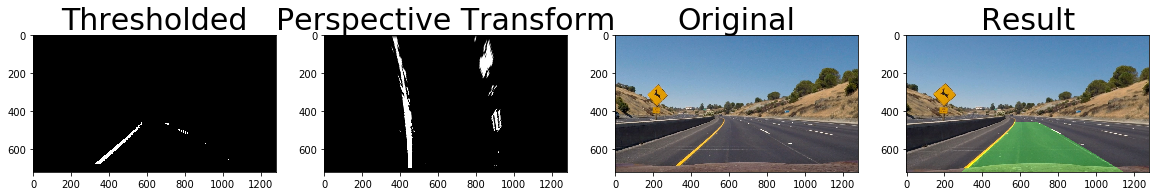

In [6]:
test_images = "./test_images/"
for image_link in os.listdir(test_images):
    image = mpimg.imread(test_images+image_link)
    result = advanced_lane_lines_pipline(image,cam,imageprocessor,lanefinder,True)

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):   
    return advanced_lane_lines_pipline(image,cam,imageprocessor,lanefinder,False)

In [ ]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


 98%|█████████▊| 1235/1261 [11:54<00:14,  1.76it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))